In [1]:
# импортируем необходимые библиотеки и классы
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
%config InlineBackend.figure_format = 'retina'

# загружаем данные
df = pd.read_csv('Data/divvy_daily.csv')

In [2]:
# смотрим частоту встречаемости разных состояний погоды
print(df['weather'].value_counts())

cloudy          1346
rain or snow      69
clear             41
not clear          2
Name: weather, dtype: int64


In [3]:
# вводим в датафрейм столбцы с погодой и температурой,
# для категориального столбца с погодой применяем
# дамми-кодирование
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temp', 'weather']
df = pd.get_dummies(df, columns=['weather'], prefix='', prefix_sep='')

In [4]:
# взглянем на первые 5 наблюдений нового датафрейма
df.head()

,ds,y,temp,clear,cloudy,not clear,rain or snow
0,2014-01-01,95,19.483158,0,0,0,1
1,2014-01-02,111,16.833333,0,0,0,1
2,2014-01-03,6,-5.633333,1,0,0,0
3,2014-01-04,181,30.007735,0,0,0,1
4,2014-01-05,32,16.756250,0,0,0,1


In [5]:
# создаем модель Prophet с мультипликативной сезонностью
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
# добавляем регрессор clear
model.add_regressor(name='clear',
                    prior_scale=10,
                    standardize='auto',
                    mode='multiplicative')
# добавляем регрессор not clear
model.add_regressor('not clear')
# добавляем регрессор rain or snow
model.add_regressor('rain or snow')

In [6]:
from datetime import timedelta

# удаляем последние 2 недели обучающих данных
train = df[df['ds'] < df['ds'].max() - timedelta(weeks=2)]

22:13:17 - cmdstanpy - INFO - Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing


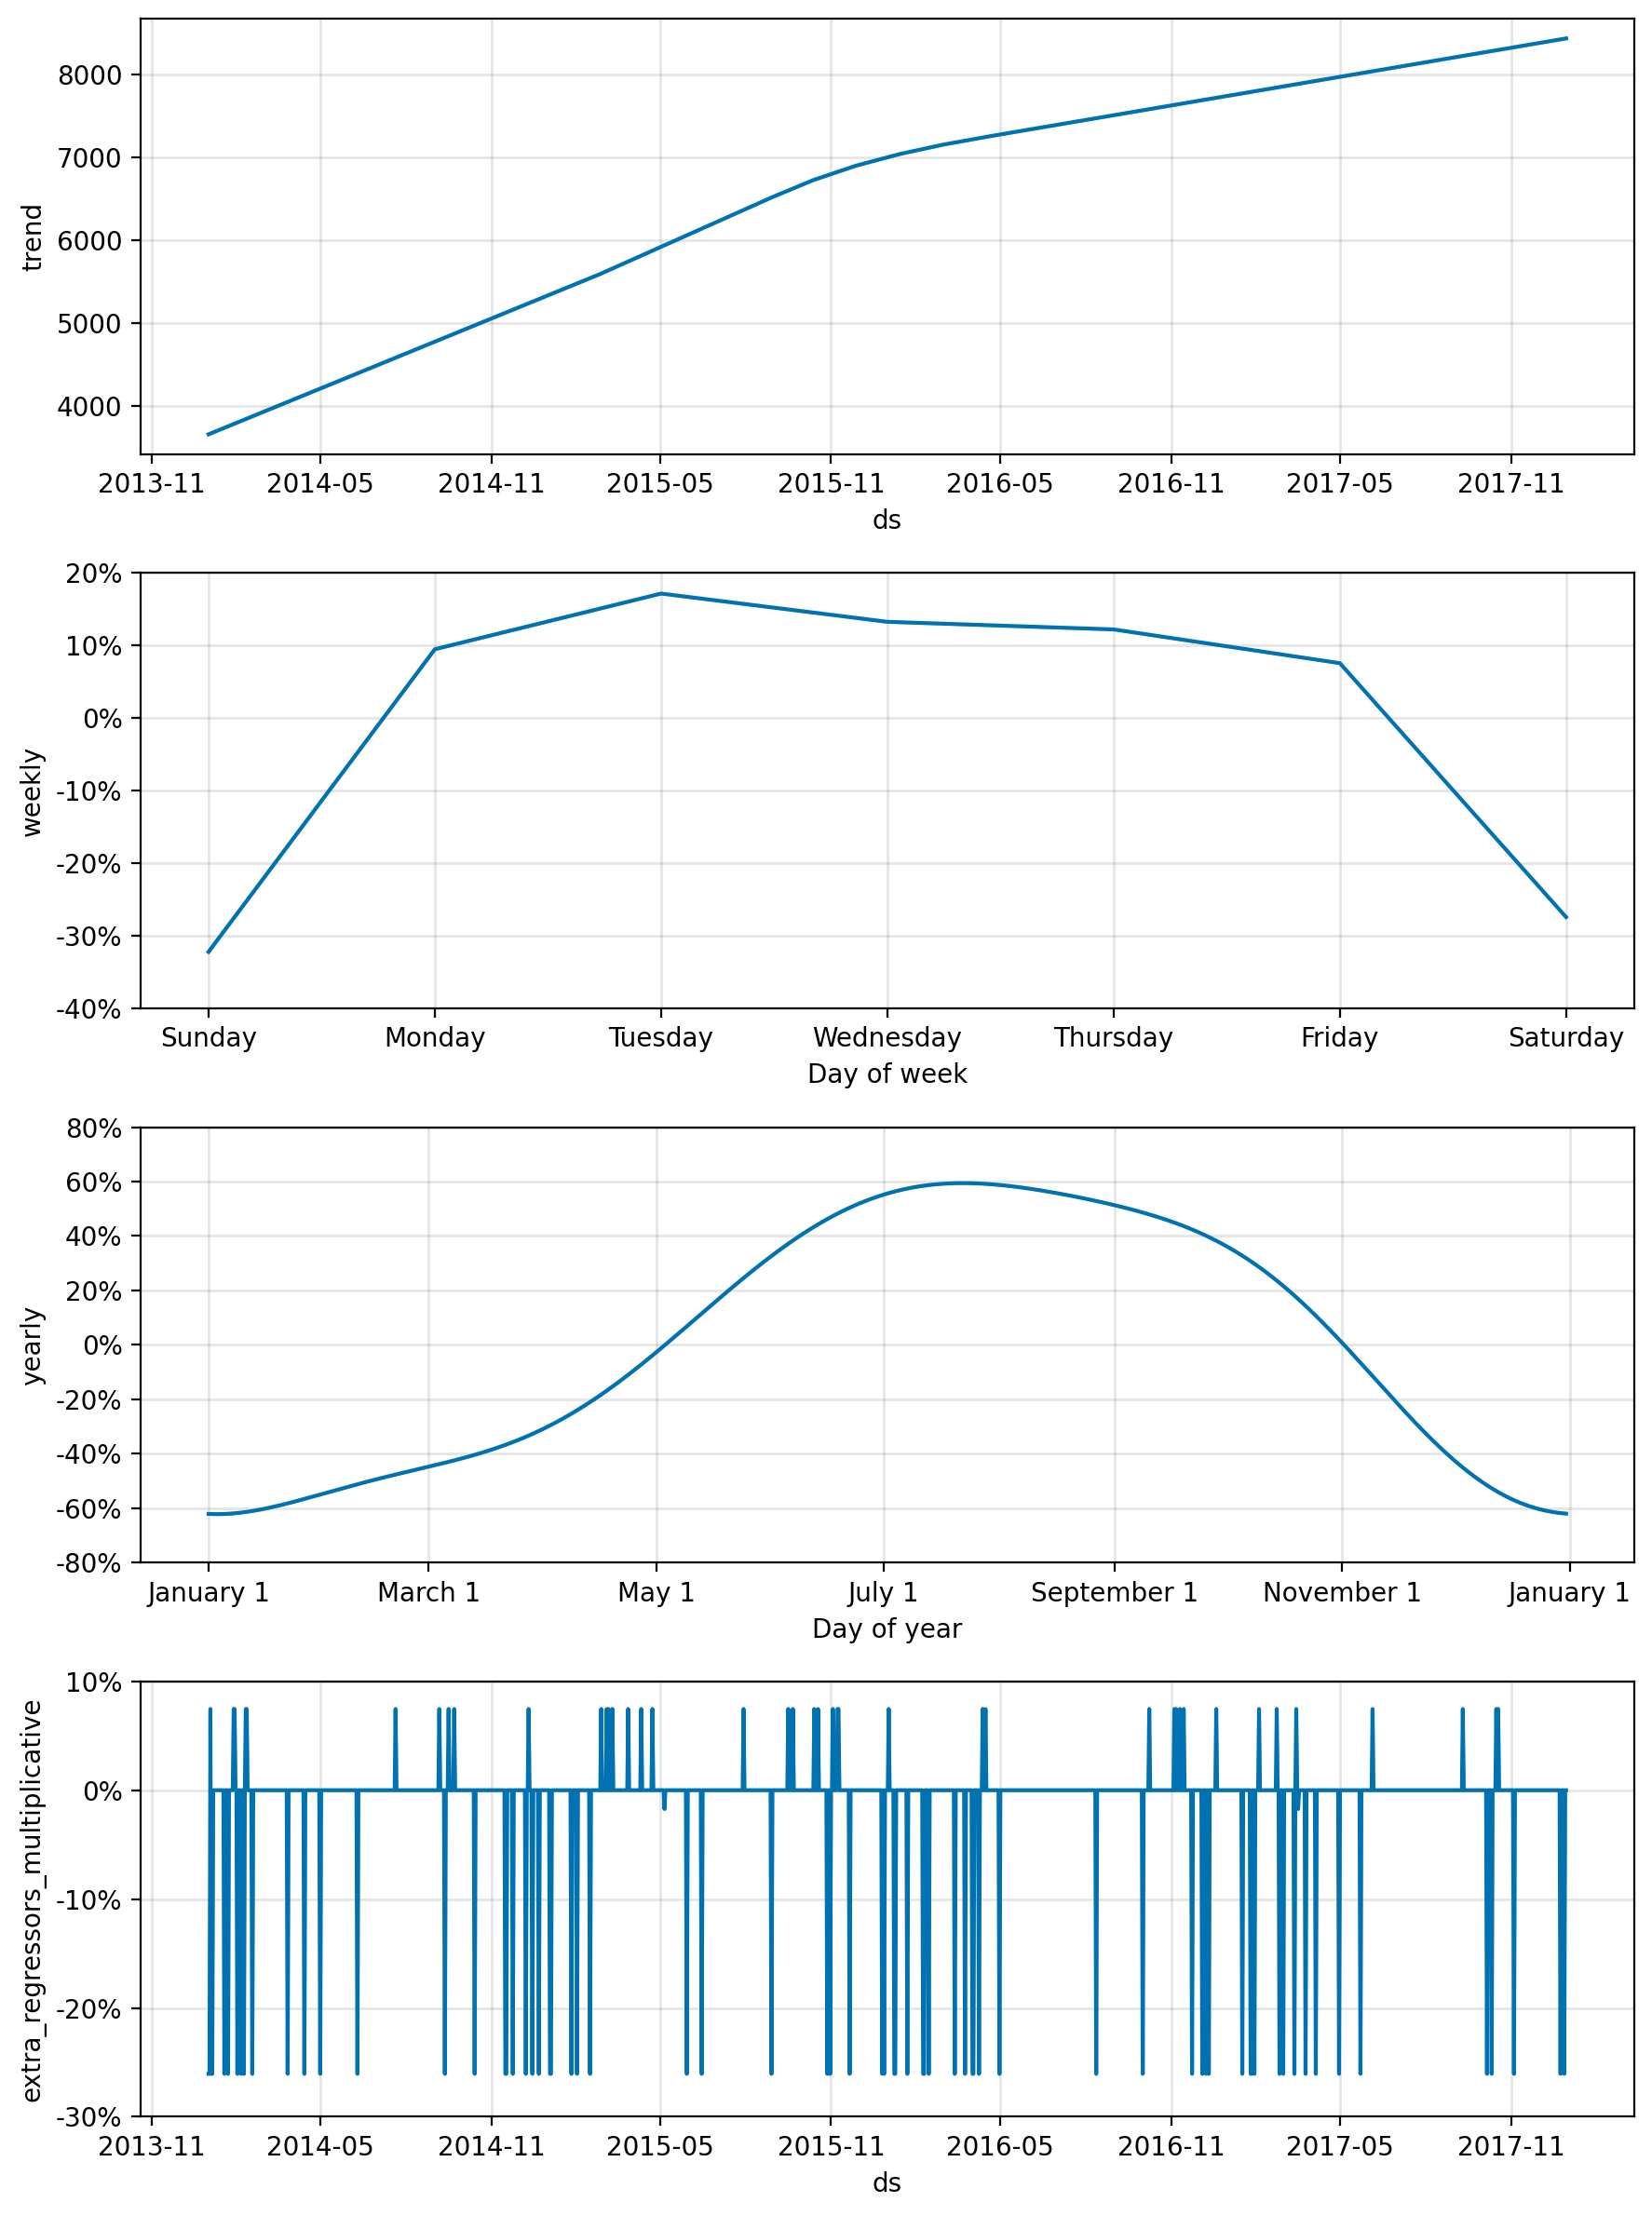

In [7]:
# обучаем модель
model.fit(train)
# создаем удлиненный датафрейм, задав горизонт 14 дней
future = model.make_future_dataframe(periods=14)
# добавляем дополнительные регрессоры
# в удлиненный датафрейм
future['clear'] = df['clear']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
# получаем прогнозы
forecast = model.predict(future)
# выводим графики компонент прогнозов
fig2 = model.plot_components(forecast)
plt.show()

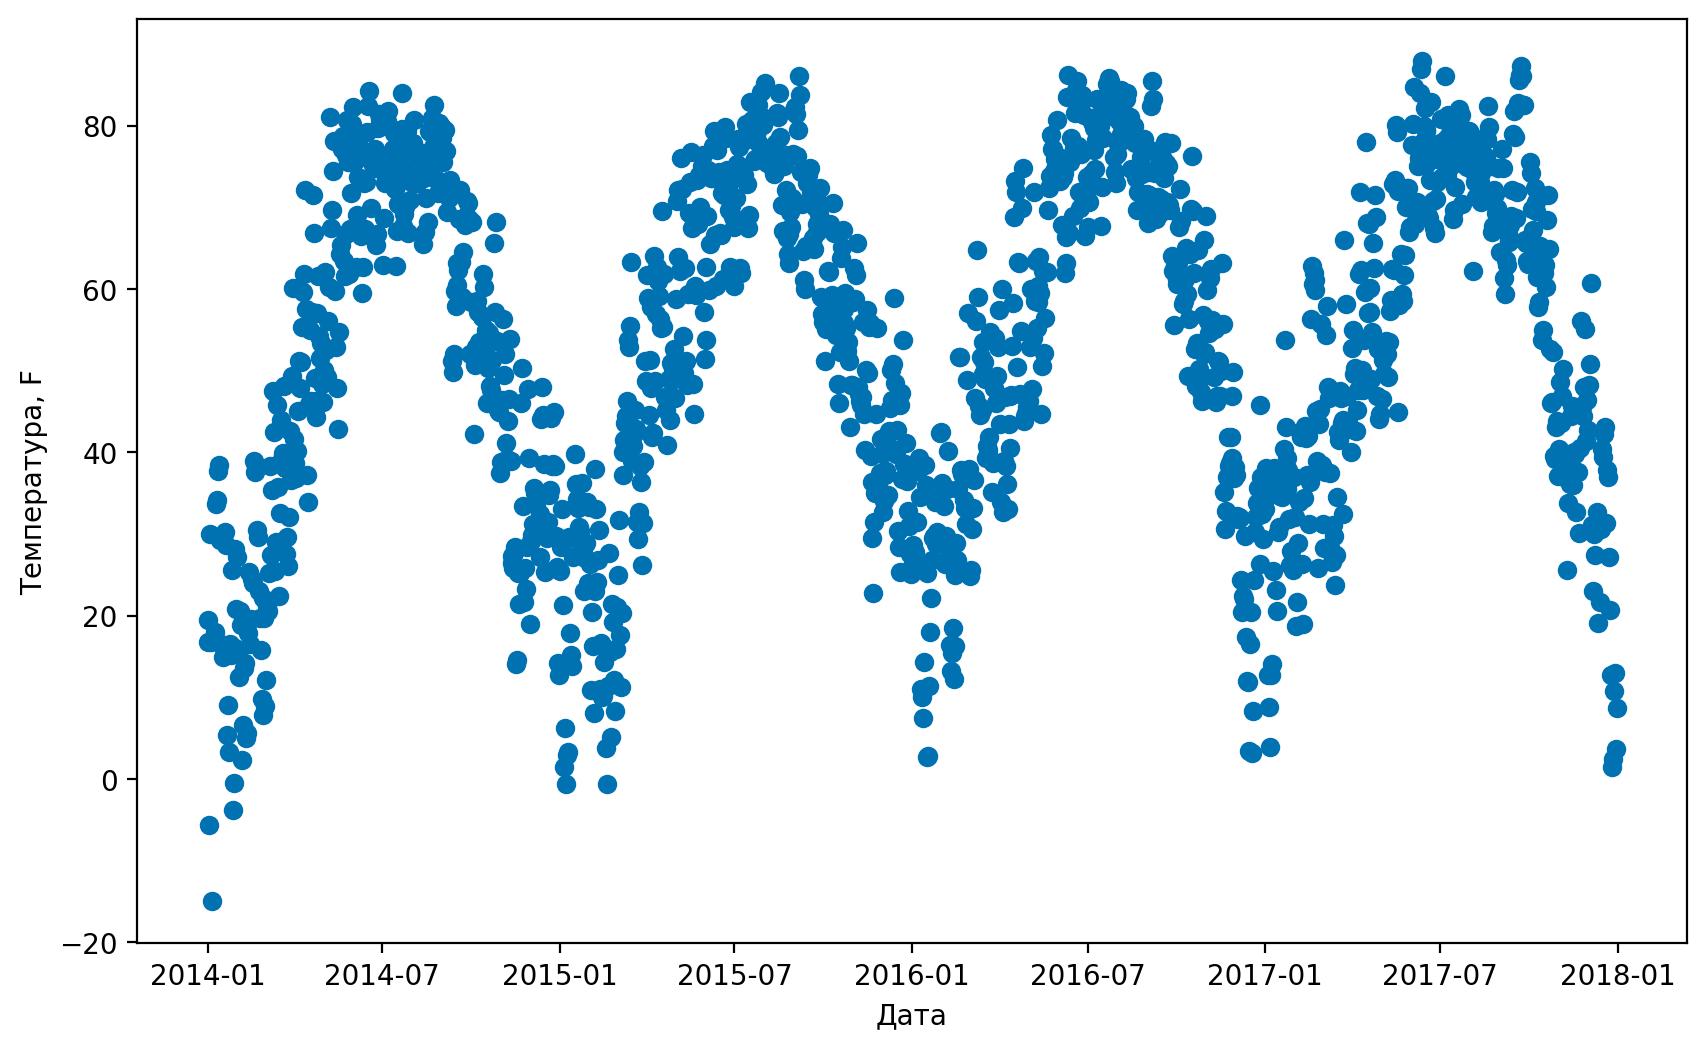

In [8]:
# визуализируем изменения температуры
plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['temp'], c='#0072B2')
plt.xlabel('Дата')
plt.ylabel('Температура, F')
plt.show()

22:13:20 - cmdstanpy - INFO - Chain [1] start processing
22:13:20 - cmdstanpy - INFO - Chain [1] done processing


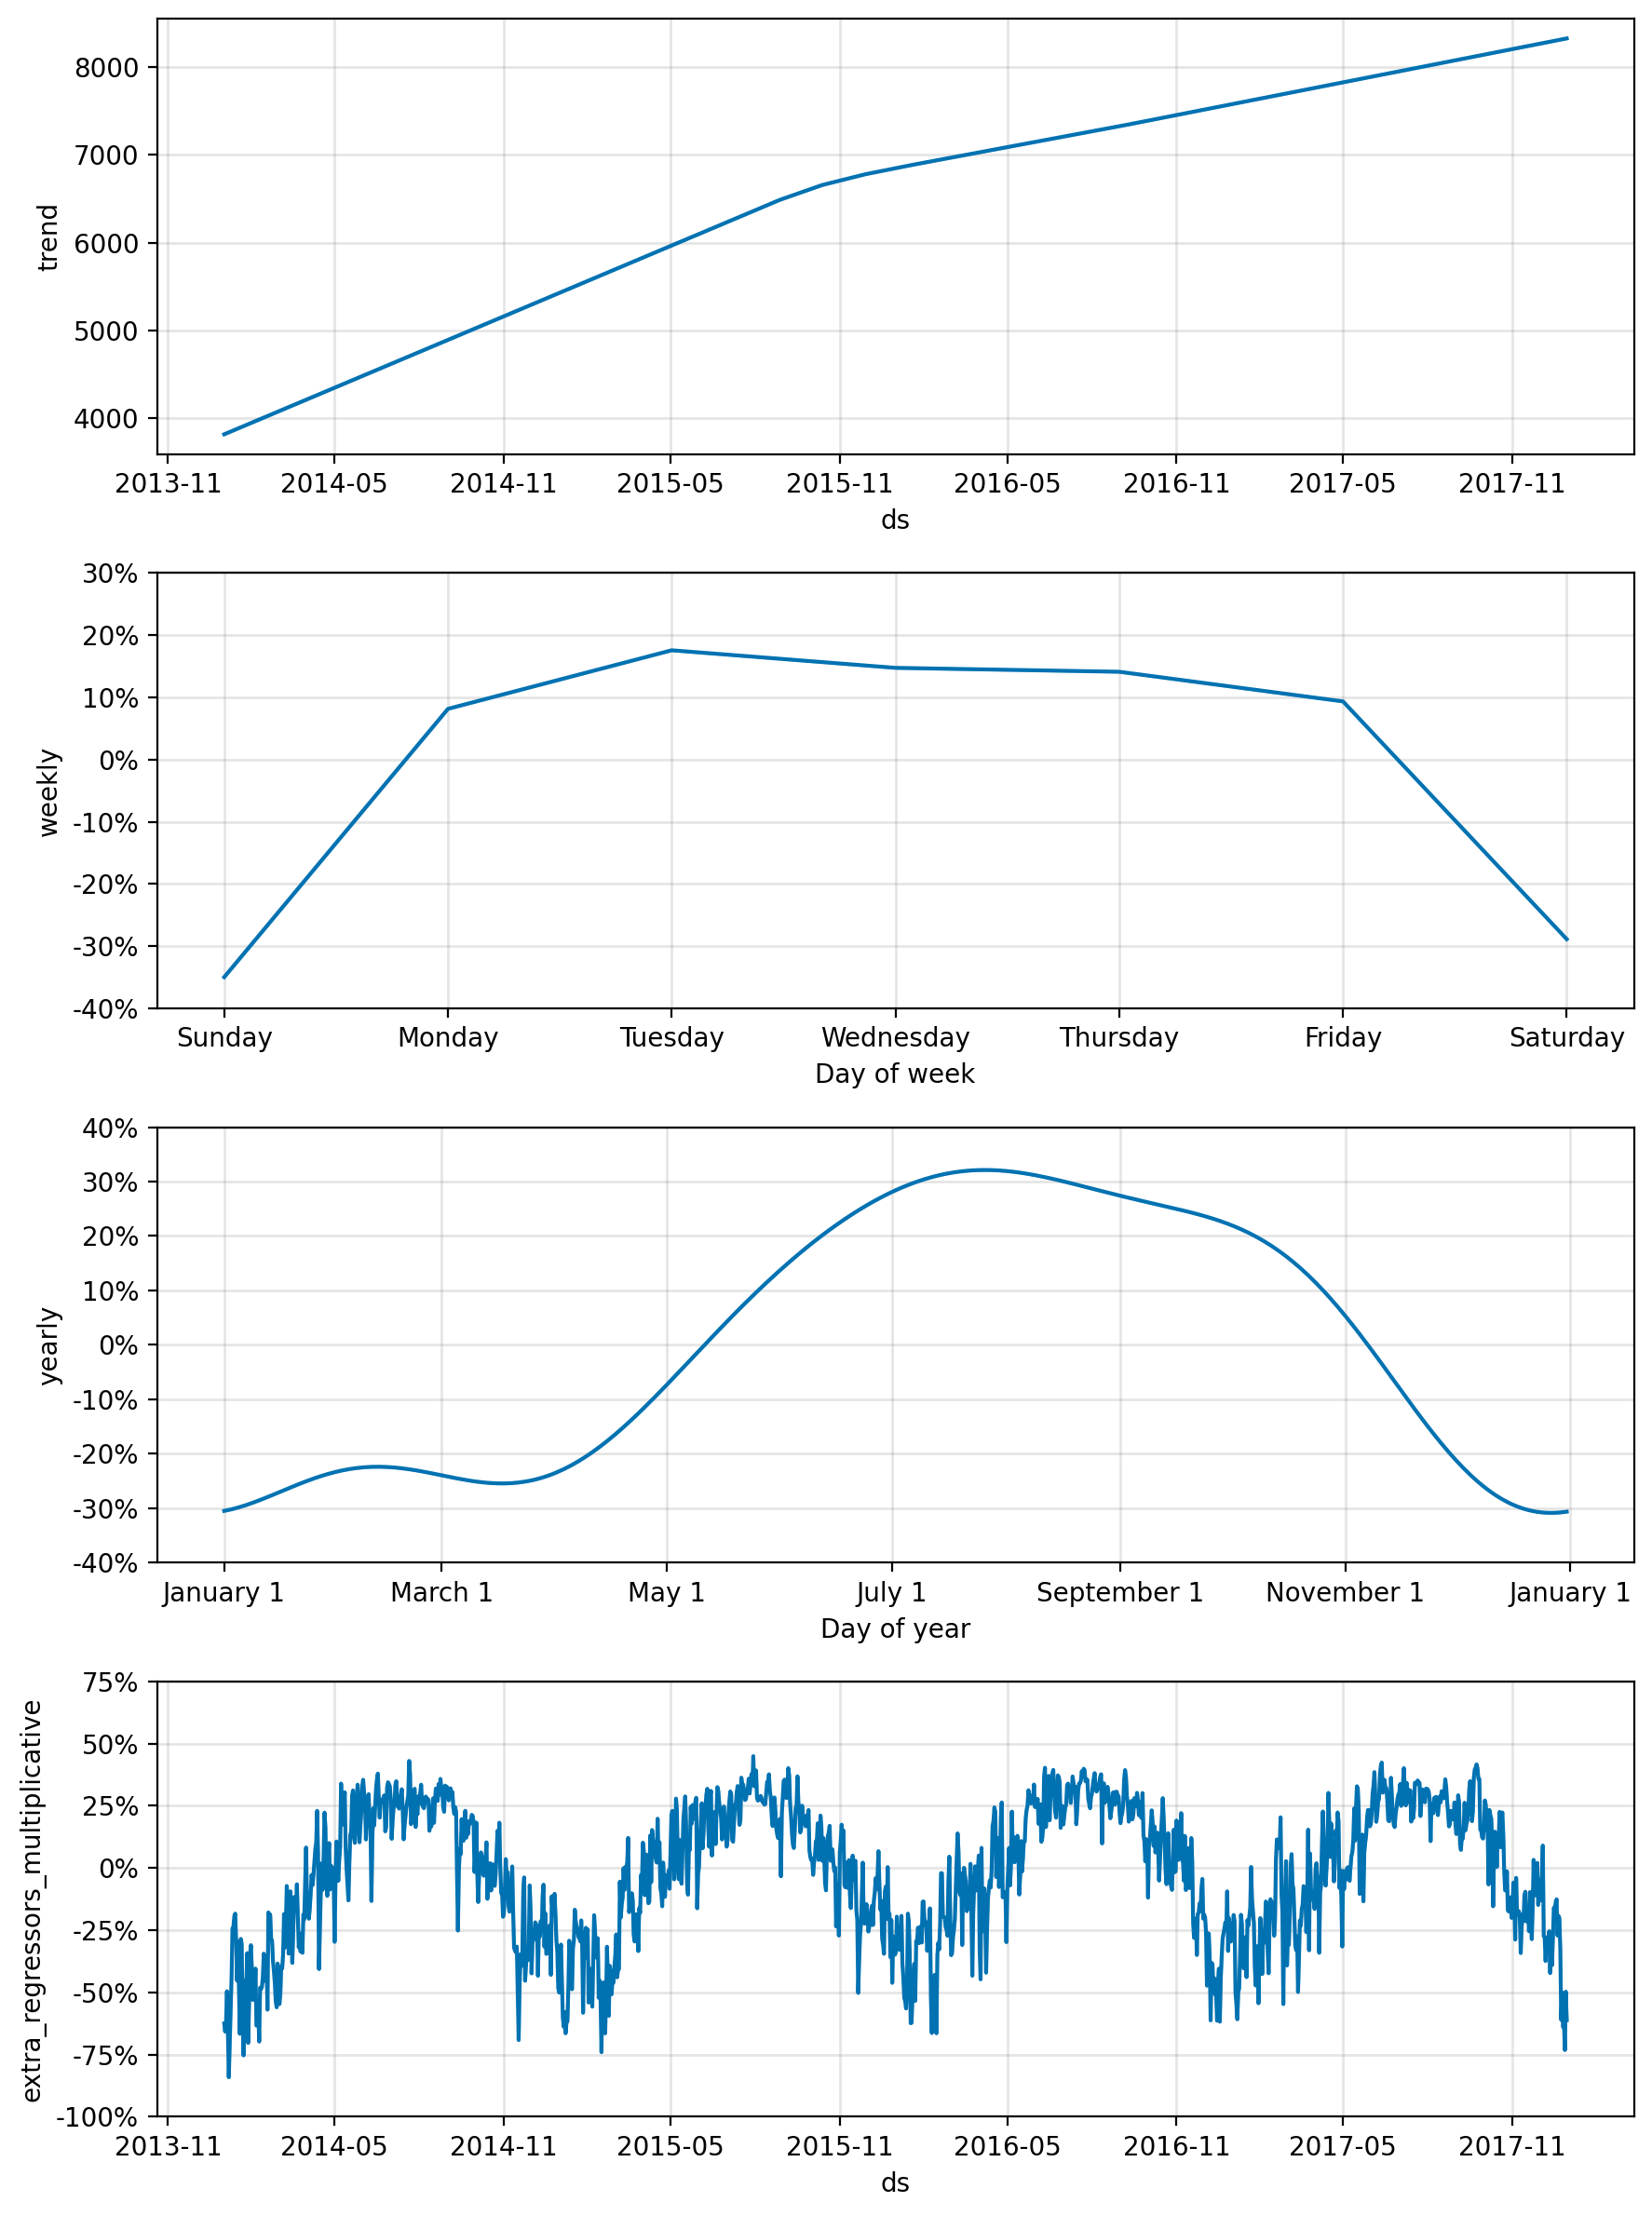

In [9]:
# создаем модель Prophet с мультипликативной сезонностью
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
# добавляем регрессоры
model.add_regressor('temp')
model.add_regressor('clear')
model.add_regressor('not clear')
model.add_regressor('rain or snow')
# обучаем модель
model.fit(train)
# создаем удлиненный датафрейм, задав горизонт 14 дней
future = model.make_future_dataframe(periods=14)
# добавляем дополнительные регрессоры 
# в удлиненный датафрейм
future['temp'] = df['temp']
future['clear'] = df['clear']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
# получаем прогнозы
forecast = model.predict(future)
# выводим графики компонент прогнозов
fig2 = model.plot_components(forecast)
plt.show() 

In [10]:
from prophet.utilities import regressor_coefficients

# извлекаем регрессионные коэффициенты
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temp,multiplicative,53.423706,0.012293,0.012293,0.012293
1,clear,multiplicative,0.000000,0.108847,0.108847,0.108847
2,not clear,multiplicative,0.000000,-0.032136,-0.032136,-0.032136
3,rain or snow,multiplicative,0.000000,-0.207800,-0.207800,-0.207800


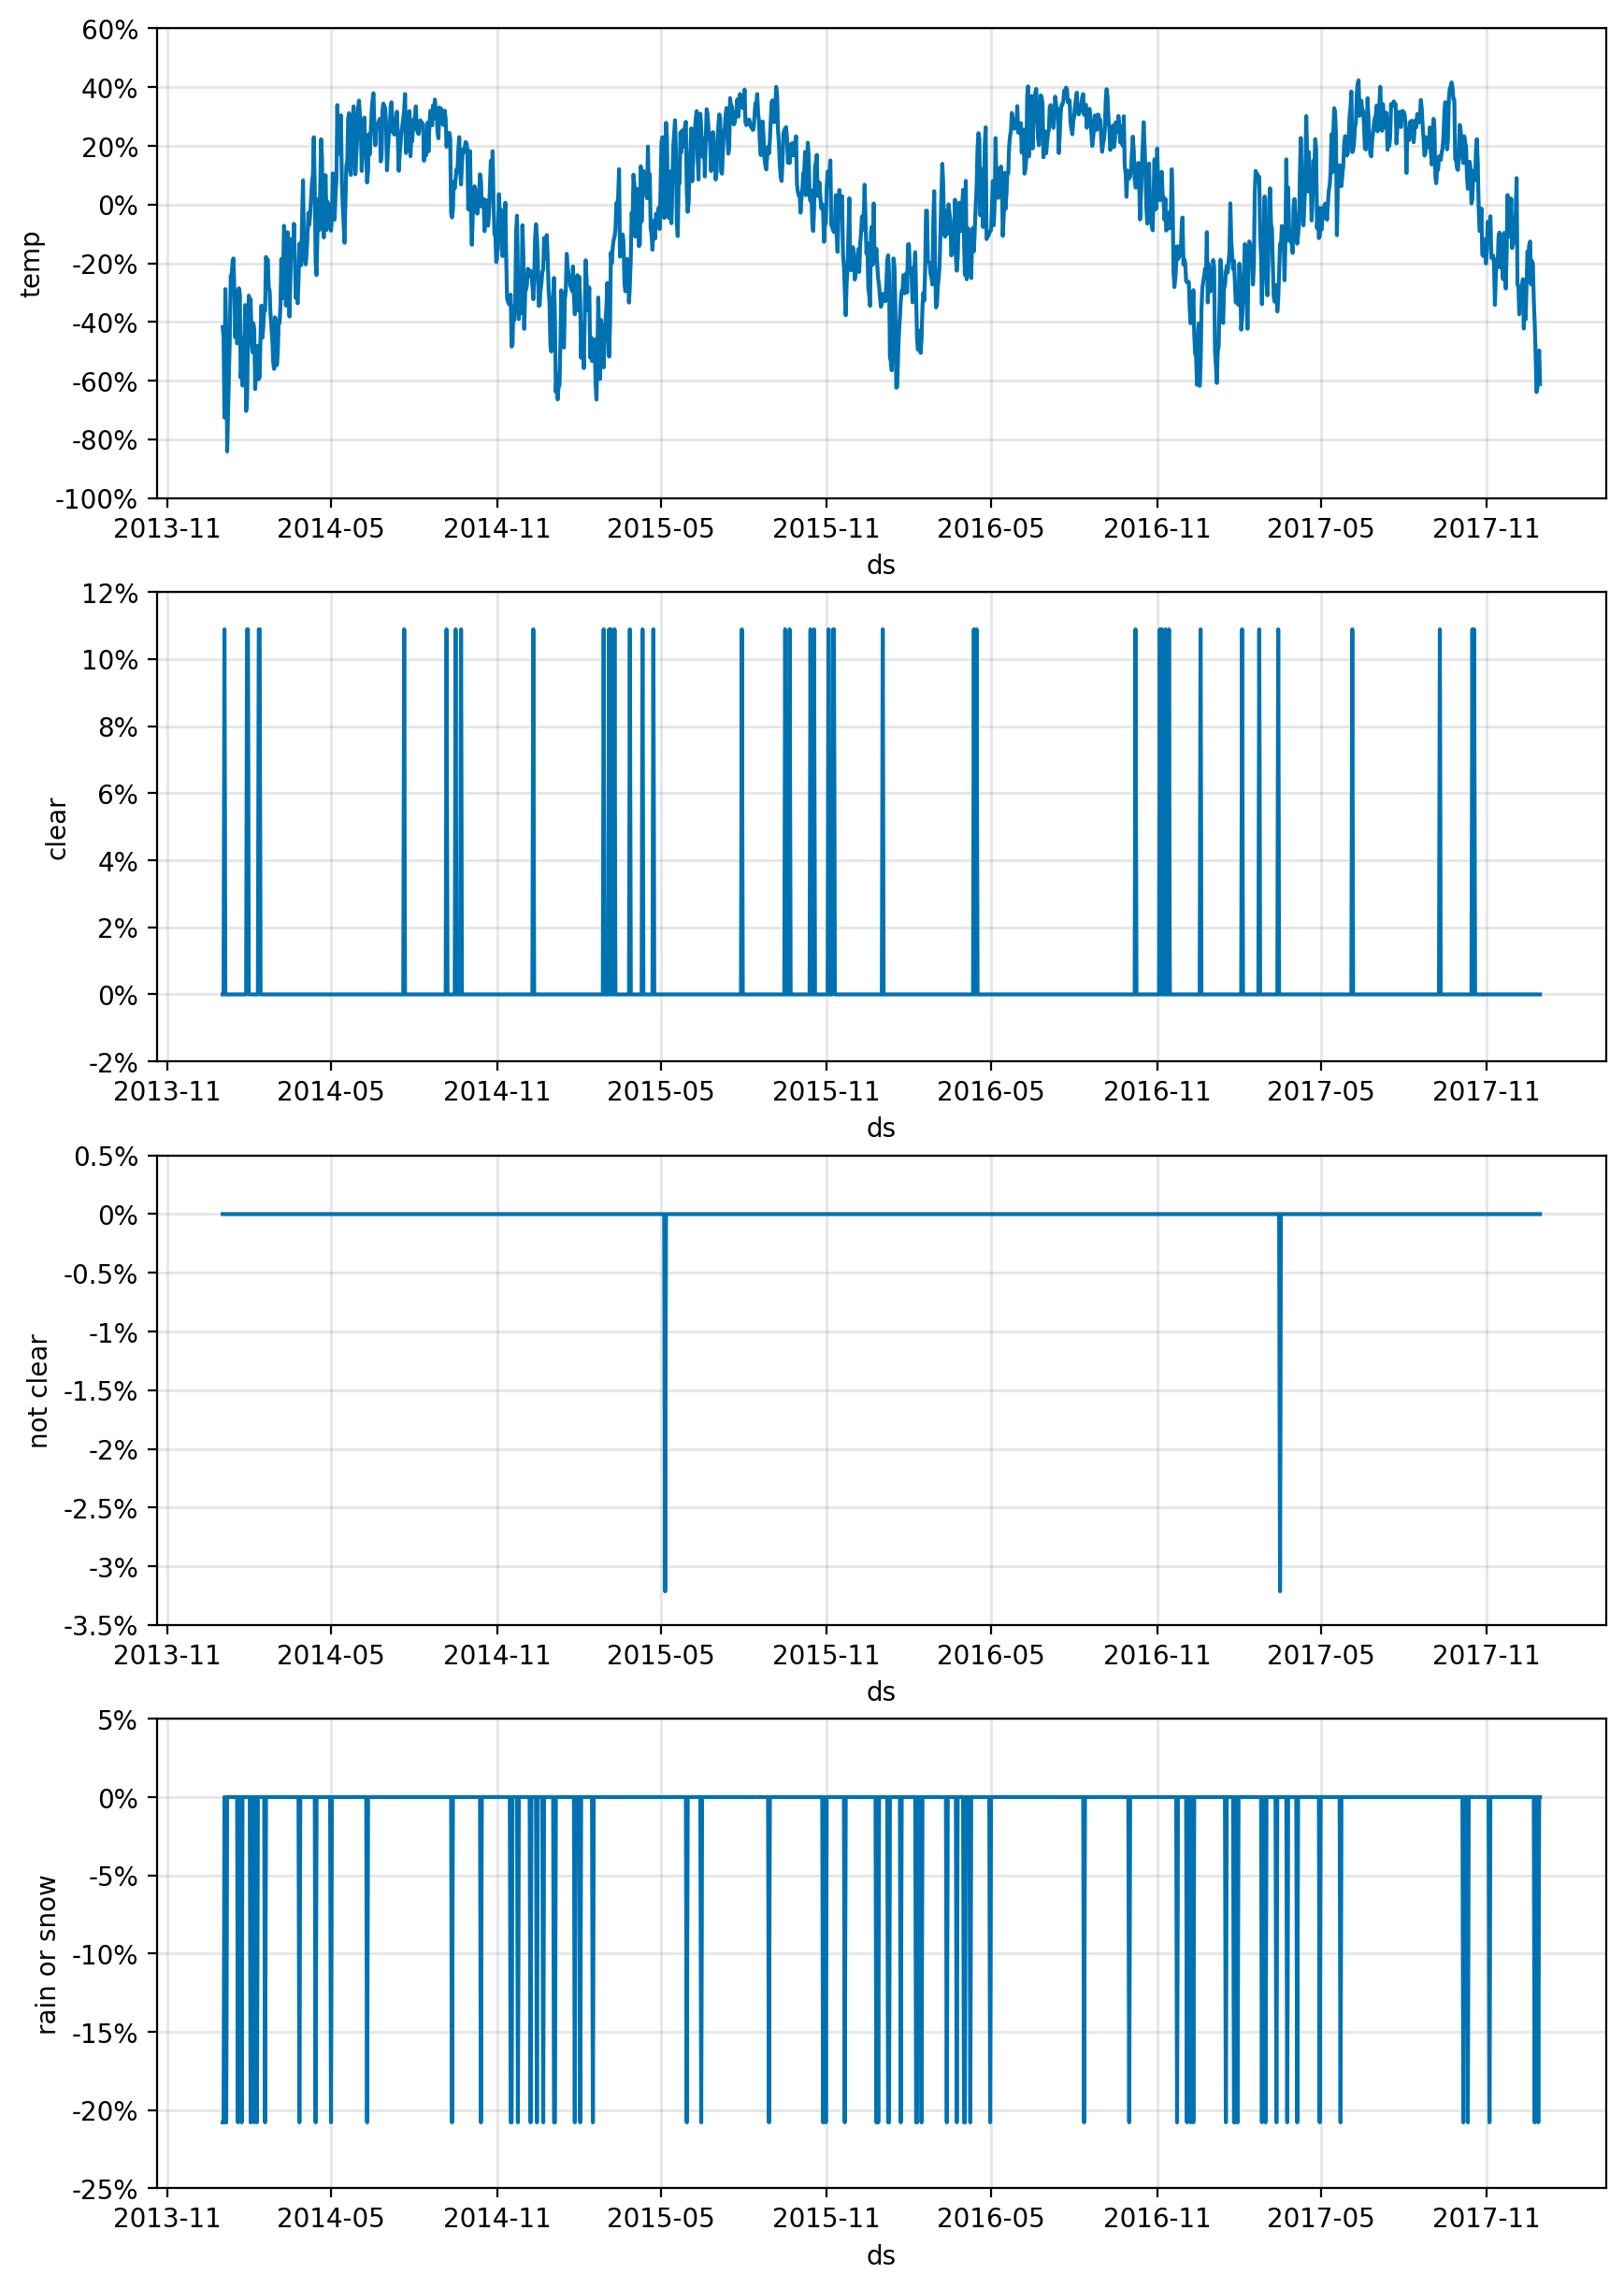

In [11]:
from prophet.plot import plot_forecast_component

# строим графики для каждого регрессора
fig, axes = plt.subplots(len(regressor_coefficients(model)),
                         figsize=(10, 15))
for i, regressor in enumerate(
    regressor_coefficients(model)['regressor']):
    plot_forecast_component(model,
                            forecast,
                            regressor,
                            axes[i])
plt.show()